In [13]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import metrics
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer

ModuleNotFoundError: No module named 'imp'

In [3]:
imaging = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/imaging.csv')
imaging = imaging.drop(columns=['COLPROT','VISCODE','VISCODE2','EXAMDATE','VERSION','LONIUID',
                                  'IMAGEUID','RUNDATE','STATUS','OVERALLQC','TEMPQC','FRONTQC','PARQC',
                                  'INSULAQC','OCCQC','BGQC','CWMQC','VENTQC','HIPPOQC','update_stamp'])
imaging = imaging.set_index('RID')

imaging = imaging.filter(regex='CV')

depression = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/medical_hist.csv')
depression = depression.set_index('RID')
depression = pd.DataFrame(depression['IHDESC'])
depression = depression[depression['IHDESC'].str.lower().isin(['depression'])]

features = imaging.copy()
features = features.loc[~features.index.duplicated(keep='last')]
features['Depression'] = features.index.isin(depression.index).astype(int)

demographics = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/demog.csv')
demographics = demographics.set_index('RID')

demographics_features = demographics[['PTMARRY','PTEDUCAT','PTHOME','PTETHCAT','PTRACCAT']]

demographics['PTDOBYY'] = 2023 - demographics['PTDOBYY']
age = demographics['PTDOBYY']
age = pd.DataFrame(age)
age = age.loc[~age.index.duplicated(keep='last')]

gender = demographics['PTGENDER']
gender = pd.DataFrame(gender)
gender = gender.loc[~gender.index.duplicated(keep='last')]

features = features.join(age, how='inner')
features = features.join(gender, how='inner')

gds = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/gds.csv')  #geriatric depression scale (5-8 mild depression, 9-11 moderate depression)
gds = gds.set_index('RID')
gds = pd.DataFrame(gds['GDTOTAL'])
gds = gds.loc[~gds.index.duplicated(keep='last')]
features = features.join(gds, how='inner')

cdr = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/cdr.csv')  #cdr dementia score (0 = no, 2/3 = dementia)
cdr = cdr.set_index('RID')
cdr = pd.DataFrame(cdr['CDGLOBAL'])
cdr = cdr.loc[~cdr.index.duplicated(keep='last')]
features = features.join(cdr, how='inner')

freesurfer_names = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/FreeSurferNames.csv')
freesurfer_names = freesurfer_names[freesurfer_names['ID'].str.contains('CV')]
freesurfer_names['NAME'] = freesurfer_names['NAME'].apply(lambda x: x.split()[-1])
freesurfer_names = freesurfer_names.set_index('ID')
freesurfer_names = freesurfer_names.to_dict()

features.rename(columns=freesurfer_names['NAME'], inplace=True)

mmse = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/mmse.csv')
mmse = mmse.set_index('RID')
mmse = pd.DataFrame(mmse['MMSCORE'])
mmse = mmse.loc[~mmse.index.duplicated(keep='last')]
features = features.join(mmse, how='inner')

fhq = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/fhq.csv')
fhq = fhq.set_index('RID')
fhq = fhq[['FHQMOM','FHQDAD','FHQSIB']]
features = features.join(fhq, how='inner')

phq = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/phq.csv')
phq = phq.set_index('RID')
phq = phq[['PHS','CIR']]
features = features.join(phq, how='inner')

medhist = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/medhist.csv')
medhist = medhist.set_index('RID')
medhist = medhist[['MHPSYCH','MH2NEURL','MH3HEAD','MH4CARD','MH5RESP','MH6HEPAT','MH7DERM','MH8MUSCL','MH9ENDO','MH10GAST','MH11HEMA','MH12RENA','MH13ALLE','MH14ALCH','MH15DRUG','MH16SMOK','MH17MALI']]
medhist = medhist.loc[~medhist.index.duplicated(keep='last')]
features = features.join(medhist, how='inner')
"""
"""

features['Dementia'] = ((features['CDGLOBAL'] > 0.6)).astype(int)
features = features.drop(columns='GDTOTAL')
features = features.drop(columns='CDGLOBAL')

In [4]:
features['Dementia'].value_counts()

Dementia
0    307
1     59
Name: count, dtype: int64

In [63]:
#without_dem = features[features['Dementia']==0].sample(n = features['Dementia'].value_counts()[1])
#with_dem = features[features['Dementia']==1]
#final = pd.concat([with_dem, without_dem])
#features = final.sample(frac=1)

In [6]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

X = features.drop(columns='Dementia')
names = X.columns.tolist()
y = features['Dementia']

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X = pd.DataFrame(X, columns=names)
y = pd.DataFrame(y)

In [7]:
space={'max_depth': hp.quniform("max_depth", 1, 60, 1),
        'gamma': hp.quniform ('gamma', 1,10,1),
        'alpha' : hp.quniform('alpha', 1,10,1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 0,20),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 20),
        'n_estimators' : hp.quniform('n_estimators', 0, 5000,10),
        'learning_rate' : hp.uniform('learning_rate', 0.0001, 1)
        #,'k' : hp.quniform('k', 10, 280,1)
    }

NameError: name 'hp' is not defined

In [87]:
def objective(space):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf=XGBClassifier(
                    n_estimators = int(space['n_estimators']),
                    max_depth = int(space['max_depth']),
                    gamma = int(space['gamma']),
                    alpha = int(space['alpha']),
                    min_child_weight=space['min_child_weight'],
                    colsample_bytree=space['colsample_bytree'],
                    scale_pos_weight=space['scale_pos_weight'],
                    learning_rate=space['learning_rate'],
                    eval_metric="error")

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=evaluation,
            #early_stopping_rounds=10,
            verbose=False)

    pred = clf.predict(X_test)
    #accuracy = accuracy_score(y_test, pred>0.5)
    f = f1_score(y_test, pred) #, average='macro'
    #print ("SCORE:", f)
    return {'loss': -f, 'status': STATUS_OK }

In [88]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

100%|██████████| 10/10 [01:13<00:00,  7.39s/trial, best loss: -0.9586776859504132]


In [89]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'alpha': 2.0, 'colsample_bytree': 0.458034767360611, 'gamma': 9.0, 'learning_rate': 0.09279120085934965, 'max_depth': 4.0, 'min_child_weight': 19.697372453605773, 'n_estimators': 3890.0, 'scale_pos_weight': 1.5103258517494966}


In [90]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train_orig)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_test = imp.fit_transform(X_test_orig)

model = XGBClassifier(alpha=int(best_hyperparams['alpha']),
                      colsample_bytree=best_hyperparams['colsample_bytree'],
                      gamma=int(best_hyperparams['gamma']), #1, #
                      learning_rate=best_hyperparams['learning_rate'],
                      max_depth=int(best_hyperparams['max_depth']), #30, #
                      min_child_weight=best_hyperparams['min_child_weight'], #2, #
                      n_estimators=10, #int(best_hyperparams['n_estimators'])
                      scale_pos_weight=best_hyperparams['scale_pos_weight'],
                      eval_metric='error')
model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test,y_test)])

predictions = model.predict(X_test)

[0]	validation_0-error:0.49695	validation_1-error:0.51220
[1]	validation_0-error:0.49695	validation_1-error:0.51220
[2]	validation_0-error:0.34420	validation_1-error:0.33333
[3]	validation_0-error:0.15886	validation_1-error:0.15447
[4]	validation_0-error:0.13646	validation_1-error:0.12195
[5]	validation_0-error:0.07332	validation_1-error:0.04878
[6]	validation_0-error:0.07128	validation_1-error:0.03252
[7]	validation_0-error:0.08350	validation_1-error:0.04065
[8]	validation_0-error:0.06517	validation_1-error:0.03252
[9]	validation_0-error:0.06314	validation_1-error:0.04065


In [91]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [92]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[59,  4],
       [ 1, 59]])

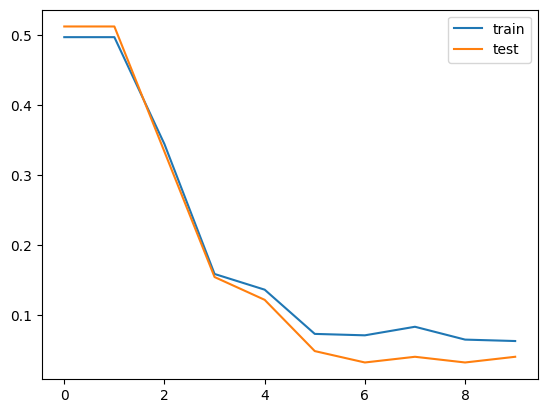

In [93]:
import matplotlib.pyplot as plt
results = model.evals_result()
plt.plot(results['validation_0']['error'], label='train')
plt.plot(results['validation_1']['error'], label='test')
plt.legend()
plt.show()

In [ ]:
!git clone https://github.com/AI-SDC/AI-SDC.git
!pip install '/content/AI-SDC/'

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import json

from os.path import expanduser

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)
home = expanduser("~")
sys.path.append(os.path.abspath(home + "/AI-SDC"))

from aisdc.attacks.multiple_attacks import (  # pylint: disable = import-error
    ConfigFile,
    MultipleAttacks,
)
from aisdc.attacks.target import Target  # pylint: disable = import-error

In [ ]:
target = Target(model=model)
target.name = "adni_dem"
target.add_processed_data(X_train, y_train, X_test, y_test)
target.add_raw_data(X, y, X_train_orig, y_train_orig, X_test_orig, y_test_orig)
for i in range(len(names)):
    target.add_feature(X.columns[i], indices=None, encoding='int')

# [Researcher] Dump the target model and target data
target.save(path="target")

In [ ]:
configfile_obj = ConfigFile(
    filename="single_config.json",
)

# Adding three worst-case attack configuration dictionaries to the JSON file
config = {
    "n_reps": 10,
    "n_dummy_reps": 1,
    "p_thresh": 0.05,
    "test_prop": 0.5,
    "train_beta": 5,
    "test_beta": 2,
    "report_name": "worstcase_example1_report",
}
configfile_obj.add_config(config, "worst_case")

config = {
    "n_reps": 20,
    "n_dummy_reps": 1,
    "p_thresh": 0.05,
    "test_prop": 0.5,
    "train_beta": 5,
    "test_beta": 2,
    "report_name": "worstcase_example2_report",
}
configfile_obj.add_config(config, "worst_case")

config = {
    "n_reps": 10,
    "n_dummy_reps": 1,
    "p_thresh": 0.05,
    "test_prop": 0.5,
    "train_beta": 5,
    "test_beta": 2,
    "report_name": "worstcase_example3_report",
    "training_preds_filename": "train_preds.csv",
    "test_preds_filename": "test_preds.csv",
    "attack_metric_success_name": "P_HIGHER_AUC",
    "attack_metric_success_thresh": 0.05,
    "attack_metric_success_comp_type": "lte",
    "attack_metric_success_count_thresh": 2,
    "attack_fail_fast": True,
}
configfile_obj.add_config(config, "worst_case")

# Adding two lira attack configuration dictionaries to the JSON file
config = {
    "n_shadow_models": 100,
    "report_name": "lira_example1_report",
    "training_data_filename": "train_data.csv",
    "test_data_filename": "test_data.csv",
    "training_preds_filename": "train_preds.csv",
    "test_preds_filename": "test_preds.csv",
    "target_model": ["sklearn.ensemble", "RandomForestClassifier"],
    "target_model_hyp": {"min_samples_split": 2, "min_samples_leaf": 1},
}
configfile_obj.add_config(config, "lira")

config = {
    "n_shadow_models": 150,
    "report_name": "lira_example2_report",
    "shadow_models_fail_fast": True,
    "n_shadow_rows_confidences_min": 10,
    "training_data_filename": "train_data.csv",
    "test_data_filename": "test_data.csv",
    "training_preds_filename": "train_preds.csv",
    "test_preds_filename": "test_preds.csv",
    "target_model": ["sklearn.ensemble", "RandomForestClassifier"],
    "target_model_hyp": {"min_samples_split": 2, "min_samples_leaf": 1},
}
configfile_obj.add_config(config, "lira")

# Adding a lira JSON configuration file to a configuration file
# having multiple attack configurations
config = {
    "n_shadow_models": 120,
    "report_name": "lira_example3_report",
    "shadow_models_fail_fast": True,
    "n_shadow_rows_confidences_min": 10,
    "training_data_filename": "train_data.csv",
    "test_data_filename": "test_data.csv",
    "training_preds_filename": "train_preds.csv",
    "test_preds_filename": "test_preds.csv",
    "target_model": ["sklearn.ensemble", "RandomForestClassifier"],
    "target_model_hyp": {"min_samples_split": 2, "min_samples_leaf": 1},
}
with open("lira_config.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(config))
configfile_obj.add_config("lira_config.json", "lira")

# Adding an attribute inference attack configuration dictionary to the JSON file
config = {
    "n_cpu": 2,
    "report_name": "aia_exampl1_report",
}
configfile_obj.add_config(config, "attribute")

# Instantiating MultipleAttacks object specifying a single configuration file
# (with multiple attacks configurations) and a single JSON output file
attack_obj = MultipleAttacks(
    config_filename="single_config.json",
    #output_filename="single_output_progammatic.json",
)
attack_obj.attack(target)

# [TRE] Runs the attack. This would be done on the command line, here we do that with os.system
# [TRE] First they access the help to work out which parameters they need to set
os.system(
    f"{sys.executable} -m aisdc.attacks.multiple_attacks run-attack-from-configfile --help"
)

# # [TRE] Then they run the attack
os.system(
    f"{sys.executable} -m aisdc.attacks.multiple_attacks run-attack-from-configfile "
    "--attack-config-json-file-name single_config.json "
    "--attack-target-folder-path target "
    "--attack-output-json-file-name single_output_cmd.json "
)